# Introduction to Deep Learning with Keras

This notebook will introduce TensorFlow and Keras, and use them to build a neural network on the classic MNIST dataset.

First, set up the environment by installing the required packages and importing the necessary functions and classes.

In [ ]:
# pip install numpy tensorflow sklearn scipy
# conda install numpy tensorflow sklearn scipy

import numpy as np

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

## Download and prepare the data

For this introduction, the classic MNIST dataset of hand-drawn digits is used.  Download the data, reshape it if necessary, and normalize it.

In [ ]:
num_classes = 10  # mnist is the 10 digits

# load the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

In [3]:
# Reshape data if necessary

# Add the channel dimension to the raw data.
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# normalize the data: set pixel values to be in range [0, 1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('First 10 values of y_train:', y_train[:10])

X_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
First 10 values of y_train: [5 0 4 1 9 2 1 3 1 4]


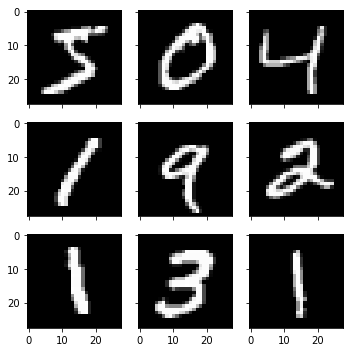

In [5]:
# View the data
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(5, 5), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(0, 9):
    ax[i].imshow(X_train[i, ..., 0], cmap='gray')
    
fig.tight_layout()
plt.show()

## Linear Classifier

First, try using a linear classifier with the MNIST data.  Below is an implmentation of a Support Vector Machine from sklearn.

In [6]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Our current shape is (batches, rows, cols, channels) but SVC expects (batches, pixels)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

model = LinearSVC()

model.fit(X_train_reshaped, y_train)

predictions = model.predict(X_test_reshaped)
print(classification_report(y_test, predictions))
print('Accuracy Score:', accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.88      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.93      0.92       982
           5       0.89      0.86      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.87      0.87       974
           9       0.90      0.89      0.89      1009

   micro avg       0.92      0.92      0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy Score: 0.9181


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


This accuracy is good, but can be improved.  We will now use tf.Keras to build a simple neural net and see how it performs.

## TensorFlow and Keras

[TensorFlow](https://www.tensorflow.org/install/) is a Python library for fast numerical computing, where computation is expressed as a data flow graph. First the graph is defined, and when training occurs, data flows through the computation graph.

[Keras](https://www.tensorflow.org/guide/keras) is a high-level API for building neural networks.  It sits on top of TensorFlow and allows developers to easily combine the basic building blocks of neural nets into *Layers*, *Objectives*, *Activations*, and *Optimizers*.

*Note:* currently our lab is only using tensorflow version 1.X

### Prepare the data for Keras

First, convert the class vectors to binary class matrices or "one-hot encode" the data.

In [7]:
# Using the keras to_categorical function to one-hot encode the data

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print(y_train[:10])

y_train shape: (60000, 10)
y_test shape: (10000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Image Data Generators

Keras also supports [`ImageDataGenerators`](https://keras.io/preprocessing/image/) which can augment data on the fly and spit out small batches of augmented data.  This can make models more robust as the training data set is greatly enlarged by the augmented data.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# augmentation rules define the affine transform matrix to apply to the data
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30)

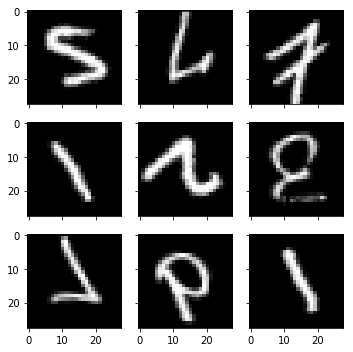

In [9]:
# View the augmented data
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(5, 5), sharex=True, sharey=True)
ax = axes.ravel()

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        ax[i].imshow(X_batch[i, ..., 0], cmap='gray')

    fig.tight_layout()
    plt.show()
    break

## Neural Networks

Let's compare our linear classifier results with simple neural networks using Keras.

### Dense Network

First, a basic one-layer example. *(Using the functional model API)*

In [10]:
inputs = Input(shape=X_train.shape[1:])
flat = Flatten()(inputs)
dense = Dense(10, activation='softmax')(flat) # output is softmax(dot(X, W) + bias)

model = Model(inputs=inputs, outputs=dense)

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(momentum=0.9, nesterov=True),
              metrics=['accuracy'])

loss = model.fit(X_train, y_train,
                 batch_size=128,
                 epochs=5,
                 verbose=1,
                 validation_data=(X_test, y_test))

W0619 14:19:48.450171 4444874176 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 10us/sample - loss: 0.5950 - acc: 0.8425 - val_loss: 0.3819 - val_acc: 0.8962
Epoch 2/5
60000/60000 [==============================] - 1s 9us/sample - loss: 0.3746 - acc: 0.8970 - val_loss: 0.3362 - val_acc: 0.9078
Epoch 3/5
60000/60000 [==============================] - 1s 9us/sample - loss: 0.3428 - acc: 0.9044 - val_loss: 0.3182 - val_acc: 0.9123
Epoch 4/5
60000/60000 [==============================] - 1s 11us/sample - loss: 0.3264 - acc: 0.9091 - val_loss: 0.3072 - val_acc: 0.9146
Epoch 5/5
60000/60000 [==============================] - 1s 9us/sample - loss: 0.3157 - acc: 0.9116 - val_loss: 0.2993 - val_acc: 0.9154


## Convolutional Network

5 epochs yield results comparable to the linear classifier, but the neural network can definitely be improved.  Below is a common pattern of Convolutions, Pooling, Dropout, and Dense layers.  [Read more about these layer types on Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network#Design) (*Using the sequential API*)

In [11]:
# Create a model with the Keras Sequential API

model = Sequential()
# 32 3x3 filters (extracting 5x5-pixel subregions), with ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Apply max filter to every 2x2 patch
model.add(Dropout(0.25)) # Drop 25% of inputs to prevent overfitting
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(momentum=0.9, nesterov=True),
              metrics=['accuracy'])

# Now using the ImageDataGenerator
loss = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                           steps_per_epoch=X_train.shape[0] // 128,
                           epochs=3,
                           verbose=1,
                           validation_data=(X_test, y_test))

Epoch 1/3
468/468 [==============================] - 62s 133ms/step - loss: 0.8943 - acc: 0.7024 - val_loss: 0.3360 - val_acc: 0.8949
Epoch 2/3
468/468 [==============================] - 56s 121ms/step - loss: 0.3962 - acc: 0.8766 - val_loss: 0.2106 - val_acc: 0.9326
Epoch 3/3
468/468 [==============================] - 56s 120ms/step - loss: 0.2945 - acc: 0.9059 - val_loss: 0.1927 - val_acc: 0.9378
